### Imports et initialisations

In [1]:
import numpy as np
# Pour l'échantillonnage aléatoire
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from clustertools import *

In [4]:
#répertoire dans lequel seront stockés les clusters, doit se terminer obligatoirement par /
cluster_dir = "clusters/1M_clusters/"
clean_dataset_file = "datasets/clean_1milliontweet.txt"
raw_dataset_file = "datasets/raw_1milliontweet.txt"

### Chargement des données en mémoire

In [5]:
with open(clean_dataset_file, "r") as file:
    lines = file.readlines()
    
clean_dataset = [line.split() for line in lines]

with open(raw_dataset_file, "r") as file:
    raw_dataset = file.readlines()

### Création des échantillons
Ne pas exécuter pour travailler avec toutes les données

In [6]:
sample_size = 5000

idx_list = random.sample(range(len
                               (clean_dataset)), sample_size)
clean_dataset = [clean_dataset[i] for i in idx_list]
raw_dataset = [raw_dataset[i] for i in idx_list]

### Encodage du jeu de données

On charge le modèle depuis le disque

In [7]:
from gensim.models import KeyedVectors

In [10]:
model = KeyedVectors.load("models/w2vec_model_d300_1M")
dim = 300

In [11]:
# Encode un message
# msg : liste de chaînes de caractères correspondant aux mots du message
# model : le modèle utilisé pour l'encodage
# dim : la dimension des vecteurs mots dans ce modèle
# Renvoie un vecteur qui est la moyenne de tous les vecteurs correspondants aux mots du message
# Si aucun mot du message n'est dans le modèle, renvoie un vecteur de zéros.
def encode(msg, model, dim):
    return np.mean([model[word] for word in msg if word in model] or [np.zeros(dim)], axis = 0)

In [12]:
%%time
#encodage de l'échantillon pour créer le jeu de données
dataset_encoded = np.array([encode(msg, model, dim) for msg in clean_dataset])

CPU times: user 185 ms, sys: 6.29 ms, total: 192 ms
Wall time: 189 ms


### Visualisation du dataset

- On réalise une réduction de dimension afin de visualiser les données dans une grille en deux dimensions
- On utilise pour cela la méthode PCA

In [13]:
%%time

pca = PCA(n_components=2)

#On crée une version en deux dimensions de notre jeu de données
two_dim_dataset = pca.fit_transform(dataset_encoded)

CPU times: user 939 ms, sys: 1.69 s, total: 2.63 s
Wall time: 459 ms


In [14]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
b = two_dim_dataset.T

#Taille des figures
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["lines.markersize"] = 3

In [15]:
# Initialisation des variables globales pour le module clustertools
init_globals(clean_dataset, raw_dataset, dataset_encoded, two_dim_dataset, cluster_dir)

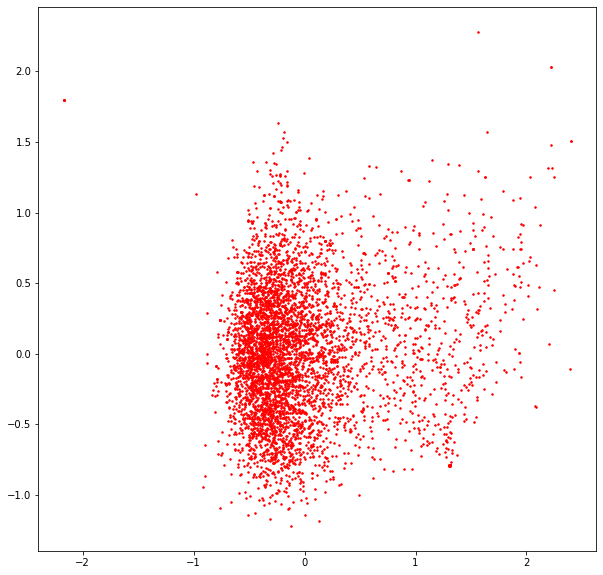

In [16]:
#Affichage des données
plt.plot(b[0], b[1], 'r.')
plt.show()

### SOM

In [17]:
from sklearn_som.som import SOM

In [18]:
%%time
som_normalized_dataset = np.array([vect / np.linalg.norm(vect) if np.linalg.norm(vect) != 0 else vect for vect in dataset_encoded])

CPU times: user 62.5 ms, sys: 29.4 ms, total: 92 ms
Wall time: 92.9 ms


In [19]:
%%time

som = SOM(m=15, n=15, dim=300)
som.fit(som_normalized_dataset)

CPU times: user 5.01 s, sys: 0 ns, total: 5.01 s
Wall time: 5.09 s


In [20]:
%%time

som_pred = som.predict(som_normalized_dataset)

CPU times: user 1.63 s, sys: 0 ns, total: 1.63 s
Wall time: 1.62 s


In [23]:
%%time

som_centers = [[r[0] for r in model.similar_by_vector(center)] for center in som.weights]

CPU times: user 15 s, sys: 2.66 s, total: 17.7 s
Wall time: 2.6 s


cluster 7 : 2 messages
Les 20 mots les plus fréquents : okis hoooooope 
Les mots les plus proches du centre : trafic alarme sudouest novembre téléphonique jeudi aveyron khartoum pacifique infotrafic 

cluster 8 : 151 messages
Les 20 mots les plus fréquents : daaaalle christianslivematter moyashi etiquételo bln frncs ilyssssssssm xafdcbcddafe barcelonaise sifily mediaverse fernans bcfaacafd ouaisouais ayayai inspirado kakeshop souriiiiiiiiiiiiire enuis krkled 
Les mots les plus proches du centre : quoooiiiiiii brûle éteindre chair pain relouuuu boucher baume flamme jus 

cluster 9 : 3 messages
Les 20 mots les plus fréquents : medicune fragmentou moiiin 
Les mots les plus proches du centre : ilyyyyysm xededcfdacdebbe mouahahaha mochate affiche nangessssss décembre dévoiler wokooo référence 

cluster 10 : 16 messages
Les 20 mots les plus fréquents : heure minorie appeler newwest jeune injouabler attaque st adangooth prix jean petit perdre tête face ca trouver signer pétition aver 
Les mot

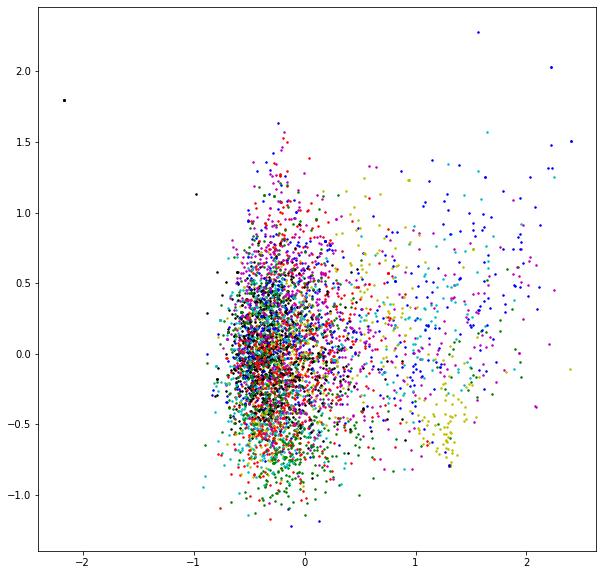

CPU times: user 559 ms, sys: 243 ms, total: 802 ms
Wall time: 809 ms


In [24]:
%%time

parse_results(som_pred, "som15x15", som_centers)